### 덧셈 역전파는 어떻게 이루어질까?
Tensor 클래스에 함수를 추가하고 .backward() 메소드에 미분계수를 더해서 임의의 연산을 지원할 수 있게 되었다.

In [4]:
import numpy as np

class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children): #텐서가 얼마나 많은 자식을 가지고 있는지 계속해서 추적한다.
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self): #텐서가 각 자식으로부터 수신한 경사도 개수가 정확한지 확인한다.
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True        
    # 3. 
    def backward(self,grad=None, grad_origin=None): #grad_origin 뿌려줄 grad를 가지고 있는 곳의 id를 grad_origin
        if(self.autograd):
            if(grad is None):
                grad = FloatTensor(np.ones_like(self.data))
            
            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0): #역전파가 가능한지 또는 경사도를 기다리고 있는 상태인지를 확인하여 후자라면 카운터를 감소시킨다.
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad #여러 자식의 경사도를 누적한다.
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):
                
                # 2-1.경사도 전파 수행
                # 2-2.해당 변수가 자동 미분을 꺼 놓는 경우(self.autograd == False),역전파를 한 번씩 거르기도 한다.
                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self) #실제 역전파를 시작.
        
                #creator를 하나만 갖고 있기 때문에 .backward()가 한 번만 호출됨.
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
  
    # 1.덧셈 메소드 구현                  
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)
    
    # 4.부정 연산 지원
    def __neg__(self):  # 매개변수는 받아들일 필요가 없기 때문에 'other' 매개변수는 삭제되었다.
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1) 
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  
    
a = Tensor([1,2,3,4,5], autograd=True)
b = Tensor([2,2,2,2,2], autograd=True)
c = Tensor([5,4,3,2,1], autograd=True)

d = a + (-b)  # (-b)를 이용해서 순전파 할 떄, 역전파되는 경사도 또한 뒤집힌 부호를 갖는다.
e = (-b) + c
f = d + e

f.backward(Tensor(np.array([1,1,1,1,1])))

print(b.grad.data == np.array([-2,-2,-2,-2,-2]))
print(a.children)
print(b.children)
print(c.children)
print(d.children)
print(e.children)
print(.
     )

SyntaxError: invalid syntax (<ipython-input-4-5db3379eecc0>, line 113)

## 덧셈 역전파는 어떻게 이루어질까?
#### 더 많은 함수를 지원하는 방법을 배우기 위해 추상화를 공부하자

In [5]:
import numpy as np

class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    act = self.creators[0]
                    weights = self.creators[1]
                    new = self.grad.mm(weights.transpose())
                    act.backward(new)
                    new = self.grad.transpose().mm(act).transpose()
                    weights.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
    
    #덧셈                
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)
    
    #부정
    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    #뺄셈
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    #곱셈
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    
    
    #총합
    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    #전개
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    #전치
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    #행렬곱셈
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  
    
a = Tensor([1,2,3,4,5], autograd=True)
b = Tensor([2,2,2,2,2], autograd=True)
c = Tensor([5,4,3,2,1], autograd=True)

d = a + b
e = b + c
f = d + e

f.backward(Tensor(np.array([1,1,1,1,1])))

print(b.grad.data == np.array([2,2,2,2,2]))

[ True  True  True  True  True]


In [6]:
x = Tensor(np.array([[1,2,3],
                     [4,5,6]]))

In [7]:
x.sum(0)

array([5, 7, 9])

In [8]:
x.sum(1)

array([ 6, 15])

In [9]:
#expand는 .sum()을 통해 역전파를 할 때 사용한다. & 차원을 따라 데이터를 복사하는 함수
x.expand(dim=0, copies=4)

array([[[1, 2, 3],
        [4, 5, 6]],

       [[1, 2, 3],
        [4, 5, 6]],

       [[1, 2, 3],
        [4, 5, 6]],

       [[1, 2, 3],
        [4, 5, 6]]])

In [10]:
x.expand(dim=1, copies=4)

array([[[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]],

       [[4, 5, 6],
        [4, 5, 6],
        [4, 5, 6],
        [4, 5, 6]]])

In [11]:
x.expand(dim=2, copies=4)

array([[[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3]],

       [[4, 4, 4, 4],
        [5, 5, 5, 5],
        [6, 6, 6, 6]]])

## 역전파 수행
* 경사도는 신경망의 마지막 끝에서 출발한다. 이제 신경망을 따라 앞으로 활성화를 이동시킬 때 사용했던 함수에 해당하는 함수를 호출함으로써 신경망을 따라 뒤로 오차 신호를 이동 시킨다. 
* 예) 마지막 연산이 행렬곱인 경우, 전치 행렬에 대해 행렬 곱(dot)을 수행해서 역전파를 한다.

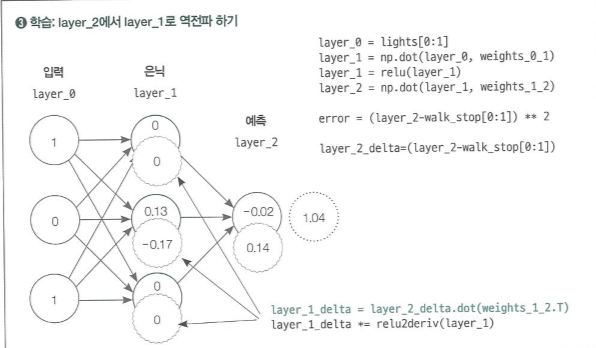

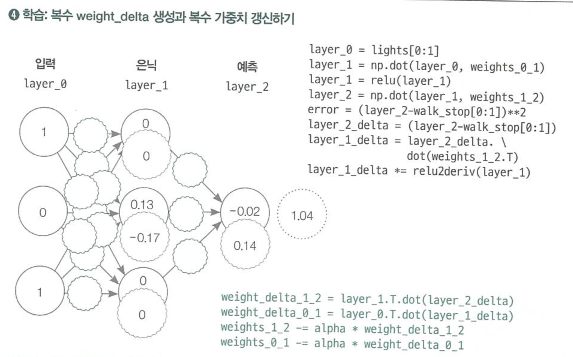

### *Previously we would train a model like this(수동으로 역전파를 하는 신경망)

In [12]:
import numpy
np.random.seed(0)

data = np.array([[0,0],[0,1],[1,0],[1,1]])
target = np.array([[0],[1],[0],[1]])

weights_0_1 = np.random.rand(2,3)
weights_1_2 = np.random.rand(3,1)

print(data)
print()
print(target)
print()

for i in range(10):
    
    # Predict
    layer_1 = data.dot(weights_0_1)
    layer_2 = layer_1.dot(weights_1_2)
    
    # Compare
    diff = (layer_2 - target) #비교
    sqdiff = (diff * diff)
    loss = sqdiff.sum(0) # mean squared error loss(평균제곱오차 손실)
    
    # Learn: this is the backpropagation piece(역전파)
    layer_1_grad = diff.dot(weights_1_2.transpose())
    weight_1_2_update = layer_1.transpose().dot(diff)
    weight_0_1_update = data.transpose().dot(layer_1_grad)
    
    weights_1_2 -= weight_1_2_update * 0.1
    weights_0_1 -= weight_0_1_update * 0.1
    print(loss[0])

[[0 0]
 [0 1]
 [1 0]
 [1 1]]

[[0]
 [1]
 [0]
 [1]]

5.066439994622395
0.4959907791902342
0.4180671892167177
0.35298133007809646
0.2972549636567377
0.2492326038163328
0.20785392075862477
0.17231260916265176
0.14193744536652986
0.11613979792168384


layer_1, layer_2, diff를 변수로 유지할 수 있는 방식으로 순전파를 수행해야 한다. 나중에 이 변수들을 다시 사용해야 하기 때문에. 
순전파를 하고 나면 각 경사도를 적절한 가중치 행렬로 역전파를 하고 적절히 가중치 갱신을 수행해야 한다.

In [9]:
import numpy
np.random.seed(0)

data = Tensor(np.array([[0,0],[0,1],[1,0],[1,1]]), autograd=True)
target = Tensor(np.array([[0],[1],[0],[1]]), autograd=True)

w = list()
w.append(Tensor(np.random.rand(2,3), autograd=True))
w.append(Tensor(np.random.rand(3,1), autograd=True))

for i in range(10):

    # Predict 예측
    prehb d = data.mm(w[0]).mm(w[1])
    
    # Compare 비교
    loss = ((pred - target)*(pred - target)).sum(0)
    
    # Learn 학습
    loss.backward(Tensor(np.ones_like(loss.data)))

    for w_ in w:
        w_.data -= w_.grad.data * 0.1
        w_.grad.data *= 0

    print(loss)

[0.58128304]
[0.48988149]
[0.41375111]
[0.34489412]
[0.28210124]
[0.2254484]
[0.17538853]
[0.1324231]
[0.09682769]
[0.06849361]


#### 임시 변수를 붙들고 씨름하지 않아도 된다.(동적 그래프가 이들을 계속 추적하기 때문에).
#### 역전파 코드를 구현할 필요도 없어졌다.(.backward() 메소드가 처리하기 때문에). 
#### 자동 미분은 편리할 뿐만 아니라 역전파를 구현하느라 저지르는 어리석은 실수와 버그를 양산할 가능성을 줄여준다.